referenced:

https://www.kaggle.com/code/prashant111/arima-model-for-time-series-forecasting

ARIMA, short for AutoRegressive Integrated Moving Average, is a forecasting algorithm based on the idea that the information in the past values of the time series can alone be used to predict the future values.

### The meaning of p, d and q in ARIMA model
* AR(p) Autoregression : p is the order of the Auto Regressive (AR) term. It refers to the number of lags of Y to be used as predictors.
* I(d) Integration : d is the minimum number of differencing needed to make the series stationary.
* MA(q) Moving Average:  q is the order of the Moving Average (MA) term

In [6]:
import pandas as pd
import numpy as np
from darts import TimeSeries
# 
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

In [1]:
import pandas as pd
import numpy as np
from darts import TimeSeries
    
# Load the electric dataset(CSV) into a Pandas DataFrame
df_el = pd.read_csv('el_price.csv', sep = ';')
# Select the desired columns
df_el = df_el[['MTU (CET/CEST)', 'Day-ahead Price [EUR/MWh]']]

# Rename the columns
df_el = df_el.rename(columns={'MTU (CET/CEST)': 'date', 'Day-ahead Price [EUR/MWh]': 'price'})

# Extract the first 16 characters from the 'date' column
df_el['date'] = df_el['date'].apply(lambda x: x[0:16])
    
# Interpolate missing values in the 'price' column using linear method
df_el['price'].interpolate(method='linear', inplace=True)

ts = TimeSeries.from_dataframe(df_el, time_col='date', value_cols = 'price', fill_missing_dates=True, freq=None)

First, I will check if the series is stationary using the Augmented Dickey Fuller test (ADF Test) from the stats models package. The reason is that we need differencing only if the series is non-stationary. Else, no differencing is needed, that is, d=0.

The null hypothesis (Ho) of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then we reject the null hypothesis and infer that the time series is indeed stationary.

so we assume, our data is stationary! our p-value is 0

In [4]:
from statsmodels.tsa.stattools import adfuller
from numpy import log

df_el['date'] = pd.to_numeric(df_el['date'], errors='coerce')

result = adfuller(df_el['price'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -7.262330
p-value: 0.000000


### find out AR(p) Autoregression

#### P = 1

C:\Users\dicod\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


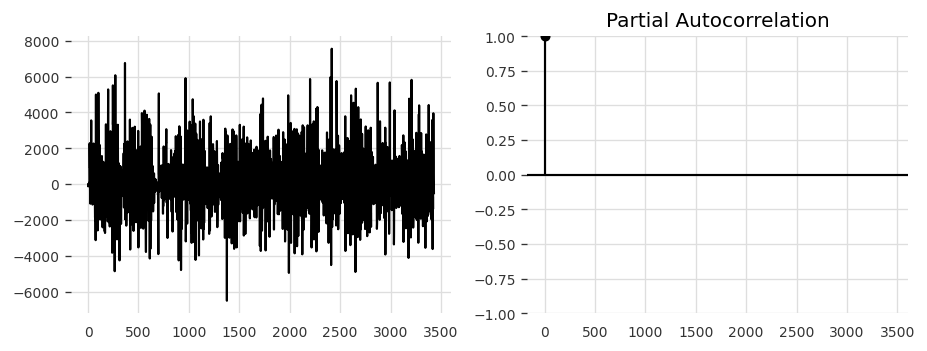

In [13]:
# PACF plot of 1st differenced series
#plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

#plt.plot(df_el.price.diff())
#plt.show()

# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df_el.price.diff())
axes[1].set(ylim=(0,5))
plot_pacf(df_el.price.diff(), ax=axes[1])

plt.show()

We can see that the PACF lag 1 is quite significant since it is well above the significance line. So, we will fix the value of p as 1.

### find out q
we will use q is o

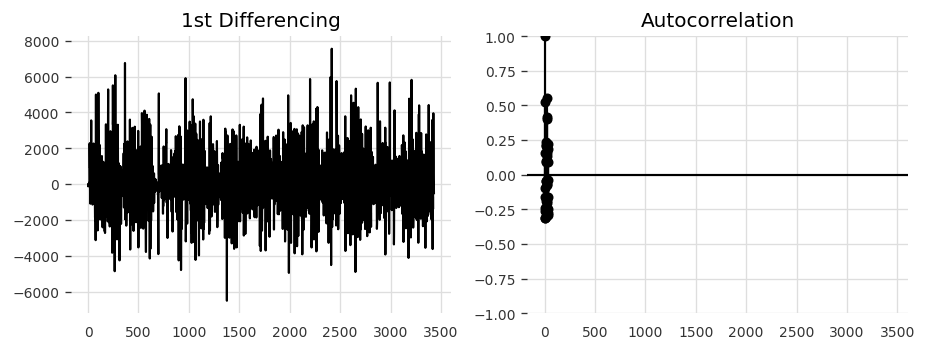

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df_el.price.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df_el.price.diff().dropna(), ax=axes[1])

plt.show()

In [28]:
train, test = ts.split_before(pd.Timestamp("01.05.2023 00:00"))

In [44]:
train_1, test_1 = ts[:-480], ts[-480:]

In [45]:
from darts.models import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(train, p=1, d=1, q=0, random_state=0, add_encoders=None)
model_fit = model.fit(train_1)
prediction = model.predict(len(test_1))

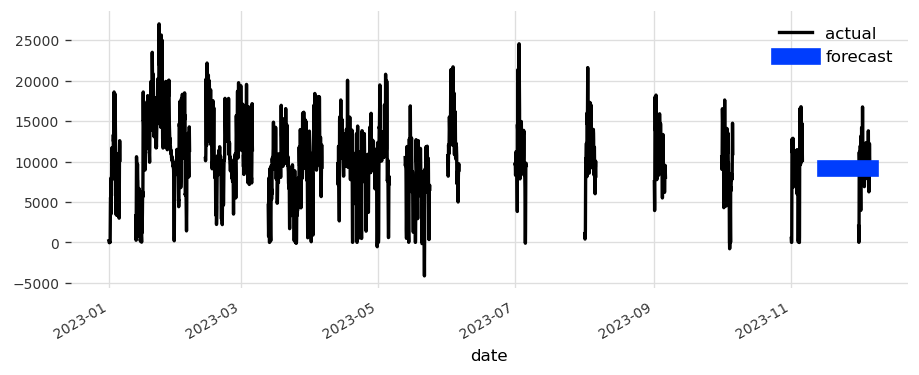

In [46]:
ts.plot(label = 'actual')
prediction.plot(label = 'forecast', lw = 10)
plt.legend()

In [25]:
from darts.models import AutoARIMA

model_aarima = AutoARIMA()
model_aarima.fit(train)
prediction_aarima = model_aarima.predict(len(test))

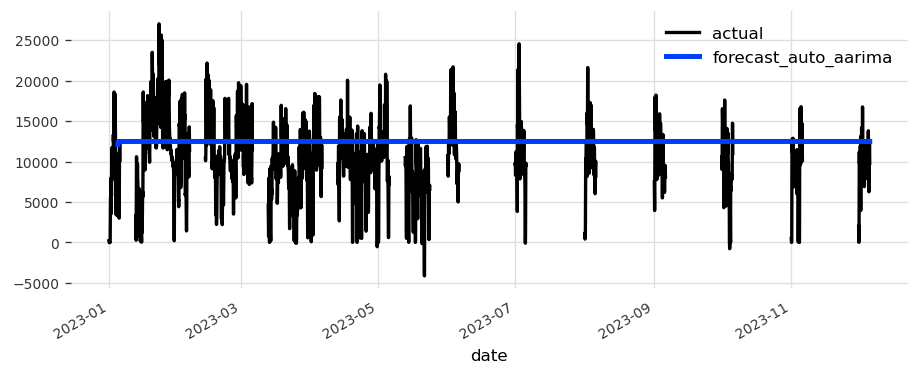

In [27]:
ts.plot(label = 'actual')
prediction_aarima.plot(label = 'forecast_auto_aarima', lw = 3)
plt.legend()

In [35]:
from statsmodels.tsa.arima.model import ARIMA

# 1,1,0 ARIMA Model
model = ARIMA(df_el.price, order=(1,1,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                 3432
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -28979.226
Date:                Wed, 24 May 2023   AIC                          57962.452
Time:                        12:18:05   BIC                          57974.733
Sample:                             0   HQIC                         57966.839
                               - 3432                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5249      0.011     47.596      0.000       0.503       0.546
sigma2      1.271e+06   1.75e+04     72.687      0.000    1.24e+06     1.3e+06
Ljung-Box (L1) (Q):                  24.89   Jarque-

In [36]:
len(ts)

8136

C:\Users\dicod\anaconda3\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from nested sequences exceeding the maximum number of dimensions of 32 is deprecated. If you mean to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


ValueError: x and y can be no greater than 2D, but have shapes (8136,) and (8136, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)

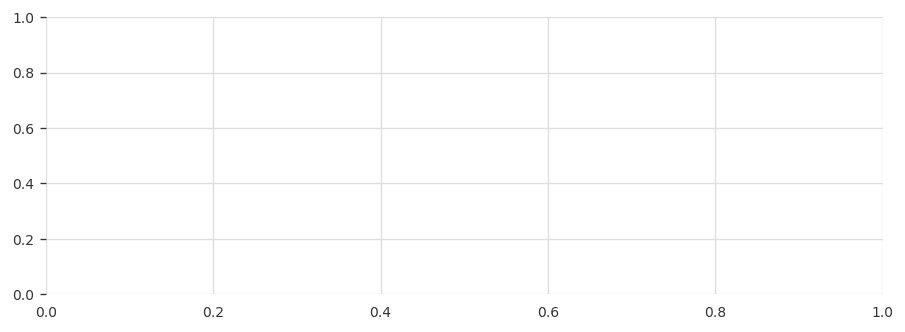

In [41]:
# Get the predicted values
predicted_values = model_fit.predict()

# Plot the actual and predicted values
plt.plot(ts, label='Actual')
plt.plot(df_el.index, predicted_values, label='Predicted')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted')
plt.show()